# MapReduce и параллельное программирование для расчёта центральных моментов случайной величины

### Теоретическая сводка

Для реализации параллельного программирования необходимо определить особую форму записи и хранения данных. Введём понятие **"Каноническая информация"** - набор неких статистик, обладающих следующими пятью свойствами:

1. **Универсальность** - любая последовательность сырых данных ($X_1, X_2,...,X_n$) может быть представлена в виде канонической информации и в уникальном виде;
2. **Полнота** - каноническая информация сохраняет всю информацию, которая была представлена в исходных исходных данных, и ее полностью достаточно для решаемой задачи;
3. **Элементарность** - каноническая информация существует даже для одного элемента;
4. **Точка отсчёта** - каноническая информация существует при отсутствии наблюдений;
5. **Комбинируемость** - композиция разных частей канонической информации должна удовлетворять аксиоме коммутативного моноида;
6. **Обновляемость** - каноническая информация способна регулярно обновляться при поступлении новых данных, чтобы их учитывать;
7. **Компактность и эффективность** - объём памяти, необходимый для хранения постоянно обновляющейся канонической информации, в идеале не зависящий от объёма наблюдений;

### Определение формы канонической информации

Ковариация и дисперсия вычисляется следующим образом:
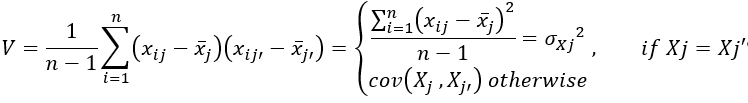

Преобразуем формулу ковариации-дисперсии, чтобы определить возможную форму канонической информации:

![title](picture.png)

Так, каноническая информация *I* имеет вид:
![title](canonical.png)
Или, обозначив элементы I за n, S, P соответственно:
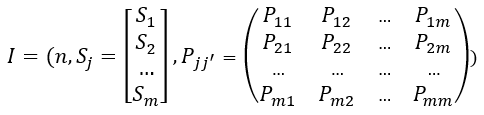

Принцип MapReduce для этой задачи можно проиллюстрировать следующим образом:

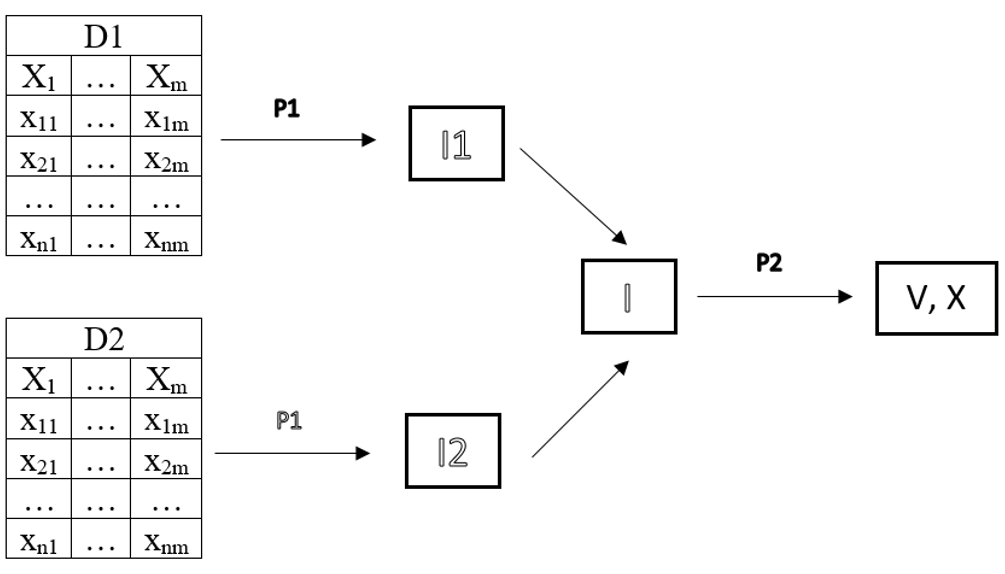

### Проверка свойств канонической информации

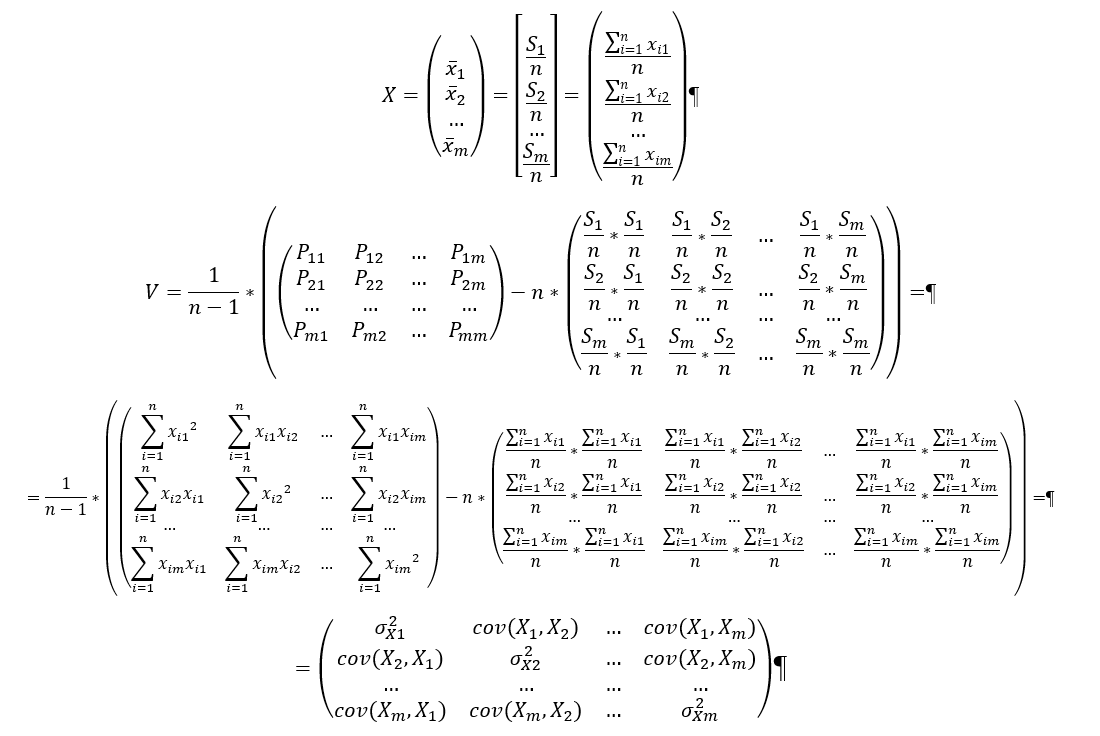

### Программная реализация

In [1]:
import numpy as np
import scipy.linalg
from functools import reduce

In [26]:
# Инициализируем исходные данные

m = 3  # число столбцов
n = 20 # число строк

X0 = np.array([[1.],[2.],[3.]])
V0 = np.array([[1., .5, .5],[.5, 1., .5],[.5, .5, 1.]])

Vs=scipy.linalg.sqrtm(V0)
X = X0 @ np.ones((1,n)) + Vs @ np.random.normal(size=(m,n))

# Запишем в nodes срезы датасета, имитируя кластер из 4 разных машин,
# хранящих собственную часть данных из исходного датасета.
nodes = [X[:,:5], X[:,5:10], X[:,10:15], X[:,15:20]]

print('Вывожу матрицу исходных наблюдений:\n', X)

Вывожу матрицу исходных наблюдений:
 [[ 0.58082265  0.88379046  0.25097271 -0.53940512 -0.02267257 -1.06442463
   2.11689364  0.86645222  0.1773734   1.35194811  0.96375013 -1.69250117
   1.27008661  0.59207208  1.20748851  1.44734643  0.22157677 -0.91139048
  -1.39868439  1.55090432]
 [ 2.5182651   2.5008123   0.02078201  0.80848987  2.62408564  1.62226763
   2.9735985   2.01913289  1.29177966  1.42475806  1.87405551  2.63102348
   2.67082689  2.63057803  2.68996023  3.60287192  3.13786865  1.559022
   0.50523922  2.98166654]
 [ 3.33027768  2.20793982  2.45721716  2.20897322  2.63637915  1.96622036
   3.94532451  3.61368997  2.68546489  3.1790837   4.11330918  3.35944457
   3.6129589   1.44501041  3.08466734  3.86495096  2.60926365  2.12205609
   0.91421694  2.98540731]]


In [27]:
nodes[0]

array([[ 0.58082265,  0.88379046,  0.25097271, -0.53940512, -0.02267257],
       [ 2.5182651 ,  2.5008123 ,  0.02078201,  0.80848987,  2.62408564],
       [ 3.33027768,  2.20793982,  2.45721716,  2.20897322,  2.63637915]])

In [7]:
# Введём функции MapReduce

def mean_map(X):
    '''
    Преобразует данные о наблюдениях в форму канонической информации
    n, S, T.
    '''
    transposeX = np.transpose(X)
    n = len(transposeX)
    S = np.sum(np.array(X), axis = 1)
    T = sum(np.outer(transposeX[i], transposeX[i]) for i in range(0, n))
    return n, S, T

def mean_reduce(x, y):
    """
    Суммирует соответствующую каноническую информацию воедино,
    возвращая каноническую информацию об исходном датасете.
    """
    return x[0]+y[0], x[1]+y[1], x[2]+y[2]

def mean_result(r):
    '''
    Вычисляет центральные моменты случайной величины, используя
    каноническую информацию об исходном датасете.
    '''
    meanX = r[1]/r[0]
    Matrix = 1/(r[0]-1)*(r[2]-np.outer(r[1], r[1])/r[0])
    return meanX, Matrix

In [14]:
# Протестируем итог

ourmeancov = mean_result(reduce(mean_reduce, map(mean_map,nodes)))
print('Our cov = ', ourmeancov[1])
print()
print('Our mean =', ourmeancov[0])
print()
truecov = np.cov(X)
truemean = np.mean(X, axis = 1)
print('True cov =', truecov)
print()
print('True mean = ', truemean)

def test(ourmeancov):
    """
    Тест равенства рассчитанных среднего и дисперсии инструментами numpy напрямую
    и с помощью канонической информации.
    Возвращает True, если результаты идентичны, иначе - False.
    """
    if (all(ourmeancov[0]) == all(truemean)):
        print('Mean is correct')
    else: 
        print('Bad')
    
    if (ourmeancov[1] == truecov).any():
        print('Good')
    else: 
        print('Bad')
        
test(ourmeancov)

Our cov =  [[1.43159623 1.16206652 1.17769404]
 [1.16206652 1.44561072 1.24928922]
 [1.17769404 1.24928922 1.8656131 ]]

Our mean = [0.71125148 1.99210665 2.70862083]

True cov = [[1.43159623 1.16206652 1.17769404]
 [1.16206652 1.44561072 1.24928922]
 [1.17769404 1.24928922 1.8656131 ]]

True mean =  [0.71125148 1.99210665 2.70862083]
Mean is correct
Good
